### Introduction


The dataset used was **StackSample: 10% of Stack Overflow Q&A** available at https://www.kaggle.com/datasets/stackoverflow/stacksample?select=Questions.csv

The challenges with this dataset were 

1. There is a large amount of text data in the body column containing multiple commas 
2. There is no obvious set of features contributing to a target column

These issues were addressed by:  

*  The multiple commas in the body column is addressed because after investigation it was found the " is used as an escape key 
*  Additional features were calculated by adding information to the questions data from the answers and tags data
*  There were two columns used for labeled data, the quesetion score and the answer score (imported for the answers csv)

### Import Required Libraries

In [0]:
# Import required libraries
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType

from pyspark.sql.functions import col, when, regexp_replace, lower, avg, round, min, max, percentile_approx, collect_list, countDistinct, expr, length, size, rand

### Import Data

In [0]:
#Import the Questions csv file

question_schema = StructType([
    StructField("id", IntegerType(), False),\
    StructField("userid", IntegerType(), False),\
    StructField("opendate", TimestampType(), True),\
    StructField("closedate", TimestampType(), True),\
    StructField("question_score", IntegerType(), True),\
    StructField("title", StringType(), True),\
    StructField("body", StringType(), True)])

# dfquest = sqlContext.read.csv("/FileStore/Kaggle_Datasets/StackSample/miniQuestions.csv", schema=question_schema, header=True, multiLine=True, escape='"') 
dfquest = sqlContext.read.csv("/FileStore/Kaggle_Datasets/StackSample/Questions.csv", schema=question_schema, header=True, multiLine=True, escape='"') 

In [0]:
#Import the Answers csv file
answer_schema = StructType([
    StructField("id", IntegerType(), False),\
    StructField("userid", IntegerType(), False),\
    StructField("answerdate", TimestampType(), True),\
    StructField("questionid", IntegerType(), True),\
    StructField("score", IntegerType(), True),\
    StructField("body", StringType(), True)])

# dfans = sqlContext.read.csv("/FileStore/Kaggle_Datasets/StackSample/miniAnswers.csv", schema=answer_schema, header=True, multiLine=True, escape='"') 
dfans = sqlContext.read.csv("/FileStore/Kaggle_Datasets/StackSample/Answers.csv", schema=answer_schema, header=True, multiLine=True, escape='"') 


In [0]:
#Import the Tags csv file

# dftags = spark.read.csv('/FileStore/Kaggle_Datasets/StackSample/miniTags.csv', inferSchema=True, header=True)
dftags = spark.read.csv('/FileStore/Kaggle_Datasets/StackSample/Tags.csv', inferSchema=True, header=True)

dftags = dftags.withColumnRenamed('Id', 'questionid').withColumnRenamed('Tag','tag')


### Data Pre-Processing

###### Pre-process the Questions Dataframe

In [0]:
# get the timestamp of the first and last question in the questions dataframe
dfquest.agg(min(dfquest["opendate"]), max(dfquest["opendate"])).show()

+-------------------+-------------------+
|      min(opendate)|      max(opendate)|
+-------------------+-------------------+
|2008-08-01 13:57:07|2016-10-19 23:57:31|
+-------------------+-------------------+



In [0]:
#remove rows with null values for owneruserid
dfquest_process = dfquest.na.drop(how='any', subset=['userid'])
dfquest_process.count()

# remove the html tags from the body column
dfquest_process = dfquest_process.withColumn('body', regexp_replace('body', "<[^>]+>", ""))

In [0]:
# add tags to the questions dataset
# use inner join to join the dfquest_process and dftags dataframe
questandtags = dfquest_process.join(dftags, dfquest_process.id == dftags.questionid)
 
# Group the tags into one row for each id
grouptags = questandtags.groupBy("id").agg(collect_list("tag").alias("tags"))
 
# Add the tags to the dfquest_process dataframe
dfquest_process = dfquest_process.join(grouptags, "id", "left")

In [0]:
#change all text to lowercase
for colname in ['title', 'body']:
    dfquest_process = dfquest_process.withColumn(colname, lower(col(colname)))
    
#remove duplicates
dfquest_process = dfquest_process.dropDuplicates()


###### Pre-process the Answers Dataframe

In [0]:
#remove rows with null values for userid
dfans_process = dfans.na.drop(how='any', subset=['userid'])

# drop the body column as it's not required as part of the project
dfans_process = dfans_process.drop('body')


###### Pre-process the Tags Dataframe

In [0]:
#check for null values in the dataframe columns
for column in dftags.columns:
    nullvalues = dftags.filter(col(column).isNull()).count()
    print(f'{column} has {nullvalues} null values')
    

questionid has 0 null values
tag has 0 null values


There is no null values in the the Tags dataframe so there are no need to drop rows with null values

In [0]:
#change all text to lowercase
dftags_process = dftags.withColumn('tag', lower(col('tag')))


#### Add additional details to the Questions dataframe

Add columns classifying questions and answers based on whether they have a high or low score. A high score is one that is higher than the the average score

In [0]:
#  add in a column which has the number of characters in the title column
dfquest_process = dfquest_process.withColumn("title_length", length(dfquest_process['title']))

# add in a column which has the number of characters in the body
dfquest_process = dfquest_process.withColumn("question_length", length(dfquest_process['body']))

# add in a column which has the number of tags
dfquest_process = dfquest_process.withColumn("number_of_tags", size(dfquest_process['tags']))

#get the average score for questions
avg_quest_score = dfquest_process.agg(round(avg("question_score"),2)).first()[0]
print(avg_quest_score)

# Add a column to the question dataframe to show whether a question has a high or low rating
dfquest_process = dfquest_process.withColumn("question_rating", when(col("question_score") > avg_quest_score, "high").otherwise("low"))

1.77


#### Add answer information to the questions dataframe

In [0]:
#get the average score for answers
avg_ans_score = dfans_process.agg(round(avg("score"),2)).first()[0]
print(avg_ans_score)

# Add a column to the answer dataframe to show whether an answer has a high or low rating
dfans_process = dfans_process.withColumn("answer_rating", when(col("score") > avg_ans_score, "high").otherwise("low"))

2.48


In [0]:
# create a dataframe with the first answer for each question
firstanswerdate = dfans_process.groupBy("questionid").agg(min("answerdate").alias("first_answerdate"))

# rename the questionid column to make it distinct during later use
firstanswerdate = firstanswerdate.withColumnRenamed("questionid", "questionidfa")

# add data from the answers dataframe to the first answers dataframe
firstanswer = firstanswerdate.join(dfans_process, (firstanswerdate.questionidfa == dfans_process.questionid) & (firstanswerdate.first_answerdate == dfans_process.answerdate), "left")

# There is a duplicate created when joining these dataframes, remove the duplicate
firstanswer = firstanswer.dropDuplicates(["questionidfa"])

firstanswer.show(5)

+------------+-------------------+------+------+-------------------+----------+-----+-------------+
|questionidfa|   first_answerdate|    id|userid|         answerdate|questionid|score|answer_rating|
+------------+-------------------+------+------+-------------------+----------+-----+-------------+
|          80|2008-08-01 16:09:47|   124|    26|2008-08-01 16:09:47|        80|   12|         high|
|          90|2008-08-01 14:45:37|    92|    61|2008-08-01 14:45:37|        90|   13|         high|
|         120|2008-09-23 22:41:11|124363| 12734|2008-09-23 22:41:11|       120|    9|         high|
|         180|2008-08-01 19:36:46|   199|    50|2008-08-01 19:36:46|       180|    1|          low|
|         260|2008-08-01 23:49:57|   269|    91|2008-08-01 23:49:57|       260|    4|         high|
+------------+-------------------+------+------+-------------------+----------+-----+-------------+
only showing top 5 rows



In [0]:
# select the columns for use in the first answer dataframe
first_answer = firstanswer.select('questionid','answer_rating', 'first_answerdate')
first_answer = first_answer.withColumnRenamed("answer_rating", "first_answer_rating")

# Join the DataFrames on the questionid column
dfquest_process = dfquest_process.join(first_answer, dfquest_process["id"] == first_answer["questionid"],"left")

In [0]:
# Group the answer data by 'questionid'
temp_df = dfans_process.groupBy("questionid")

# Get the maximum 'score' column and the earliest answerdate (in case there are duplciate max scores)
tempdf1 = temp_df.agg(max("score").alias("best_answerscore"), min("answerdate").alias("best_answerdate"))

# Select the columns 'questionid', 'score' and 'answerdate'
bestscores = tempdf1.select("questionid","best_answerscore","best_answerdate")

# Rename the questionid column to avoid later ambiguity
bestscores = bestscores.withColumnRenamed("questionid", "bestquestionid")

# Delete uneeded dataframes
del temp_df
del tempdf1

# View the first 5 rows of the dataframe
bestscores.show(5)

+--------------+----------------+-------------------+
|bestquestionid|best_answerscore|    best_answerdate|
+--------------+----------------+-------------------+
|          7880|              24|2008-08-11 15:58:06|
|         14570|               2|2008-08-18 13:32:51|
|         32460|               5|2008-08-28 14:52:16|
|         56680|               6|2008-09-11 15:36:40|
|         57020|              18|2008-09-11 16:19:10|
+--------------+----------------+-------------------+
only showing top 5 rows



In [0]:
# Join the DataFrames on the questionid column
temp_df = dfquest_process.join(bestscores, dfquest_process["id"] == bestscores["bestquestionid"],"left")

# Select the columns you want to keep
dfquest_process = temp_df

# delete the temporary dataframe
del temp_df

# print the schema of the dataframe
dfquest_process.printSchema()

root
 |-- id: integer (nullable = true)
 |-- userid: integer (nullable = true)
 |-- opendate: timestamp (nullable = true)
 |-- closedate: timestamp (nullable = true)
 |-- question_score: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- body: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- title_length: integer (nullable = true)
 |-- question_length: integer (nullable = true)
 |-- number_of_tags: integer (nullable = false)
 |-- question_rating: string (nullable = false)
 |-- questionid: integer (nullable = true)
 |-- first_answer_rating: string (nullable = true)
 |-- first_answerdate: timestamp (nullable = true)
 |-- bestquestionid: integer (nullable = true)
 |-- best_answerscore: integer (nullable = true)
 |-- best_answerdate: timestamp (nullable = true)



#### Calculate how quickly a question is answered

In [0]:

#calculate the time it took to get the first answer
dfquest_process = dfquest_process.withColumn("first_answertime", col("first_answerdate").cast("long") - col("opendate").cast("long"))

#calculate the time it took to get it's best answer
dfquest_process = dfquest_process.withColumn("best_answertime", col("best_answerdate").cast("long") - col("opendate").cast("long"))

#Add a column to show if the best answer had a high or low rating
dfquest_process = dfquest_process.withColumn("bestanswer_rating", when(col("best_answerscore") > avg_ans_score, "high").otherwise("low"))

# remove rows with null values for the best_answerscore column as this means there was no answer for that question
dfquest_process = dfquest_process.dropna(how='any', subset=['best_answerscore','best_answerdate'])

#drop columns no longer required
dfquest_process = dfquest_process.drop('opendate', 'closedate', 'first_answerdate', 'best_answerdate','questionid','bestquestionid','best_answerscore','question_score')

### Test the Hypothesis

##### Most questions will be related to the same 5 programming languages e.g., Python, Java, JavaScript, Kotlin and R

In [0]:
# create views to use in sql queries
dfquest_process.createOrReplaceTempView("Questions")
dfans_process.createOrReplaceTempView("Answers")
dftags_process.createOrReplaceTempView("Tags")

In [0]:
from pyspark.sql.functions import desc
from pyspark.sql.functions import desc, sum, cast, count

# View the top 5 most popular languages based on tags
spark.sql("select tag, count(*) as count from Tags group by tag order by count desc limit 5").show()

# get the total number of tags using the top 5 languages
top_5_tags = dftags_process.groupBy("tag").count().sort(desc("count")).select("tag","count").limit(5)
top_5_tag_total = top_5_tags.agg(sum("count").alias("top_5_total"))
top_5_tag_total.show()

# get the total number of tags which are not in the top 5 languages
total_tags = dftags_process.agg(count("*").alias("total_count"))
total_tags = total_tags.crossJoin(top_5_tag_total)
total_rest_tags = total_tags.selectExpr("total_count - top_5_total as rest_tags")
total_rest_tags.show()


+----------+------+
|       tag| count|
+----------+------+
|javascript|124155|
|      java|115212|
|        c#|101186|
|       php| 98808|
|   android| 90659|
+----------+------+

+-----------+
|top_5_total|
+-----------+
|     530020|
+-----------+

+---------+
|rest_tags|
+---------+
|  3220974|
+---------+



<Figure size 432x288 with 0 Axes>

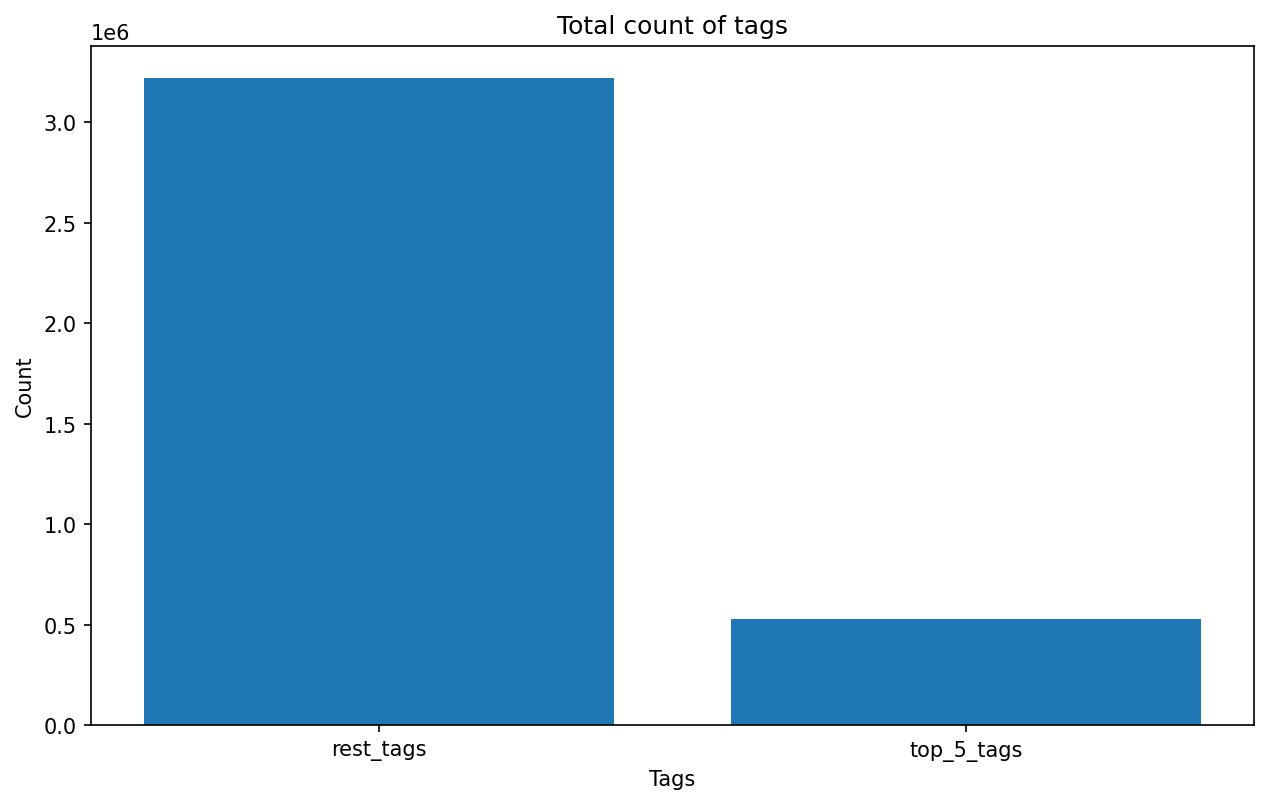

In [0]:
# plot the dataframe
import matplotlib.pyplot as plt

# Extract the values from the DataFrames
rest_tags = total_rest_tags.select("rest_tags").toPandas()
top_5_tags = top_5_tag_total.select("top_5_total").toPandas()

#clear settings for matplotlib
plt.clf()

# set the size of the graph that will be plotted
plt.figure(figsize=(10,6),dpi=150)

# Create the bar chart
plt.bar(["rest_tags", "top_5_tags"], [rest_tags["rest_tags"][0], top_5_tags["top_5_total"][0]])

# Add a title and axis labels
plt.title("Total count of tags")
plt.xlabel("Tags")
plt.ylabel("Count")

# Display the chart
plt.show()


From this output is is obvious that the hypothesis   
"Most questions will be related to the same 5 programming languages"  
is false

In [0]:
from pyspark.sql.functions import desc
from pyspark.sql.functions import desc, sum, cast, count

# View the top 20 most popular languages based on tags
spark.sql("select tag, count(*) as count from Tags group by tag order by count desc limit 20").show()

# get the total number of tags using the top 5 languages
top_20_tags = dftags_process.groupBy("tag").count().sort(desc("count")).select("tag","count").limit(20)
top_20_tag_total = top_20_tags.agg(sum("count").alias("top_20_total"))
top_20_tag_total.show()

# get the total number of tags which are not in the top 20 languages
total_tags = dftags_process.agg(count("*").alias("total_count"))
total_tags = total_tags.crossJoin(top_20_tag_total)
total_rest_tags = total_tags.selectExpr("total_count - top_20_total as rest_tags")
total_rest_tags.show()

+-------------+------+
|          tag| count|
+-------------+------+
|   javascript|124155|
|         java|115212|
|           c#|101186|
|          php| 98808|
|      android| 90659|
|       jquery| 78542|
|       python| 64601|
|         html| 58976|
|          c++| 47591|
|          ios| 47009|
|        mysql| 42464|
|          css| 42308|
|          sql| 35782|
|      asp.net| 29970|
|  objective-c| 26922|
|ruby-on-rails| 25789|
|         .net| 24059|
|            c| 23238|
|       iphone| 21539|
|    angularjs| 20345|
+-------------+------+

+------------+
|top_20_total|
+------------+
|     1119155|
+------------+

+---------+
|rest_tags|
+---------+
|  2631839|
+---------+



<Figure size 432x288 with 0 Axes>

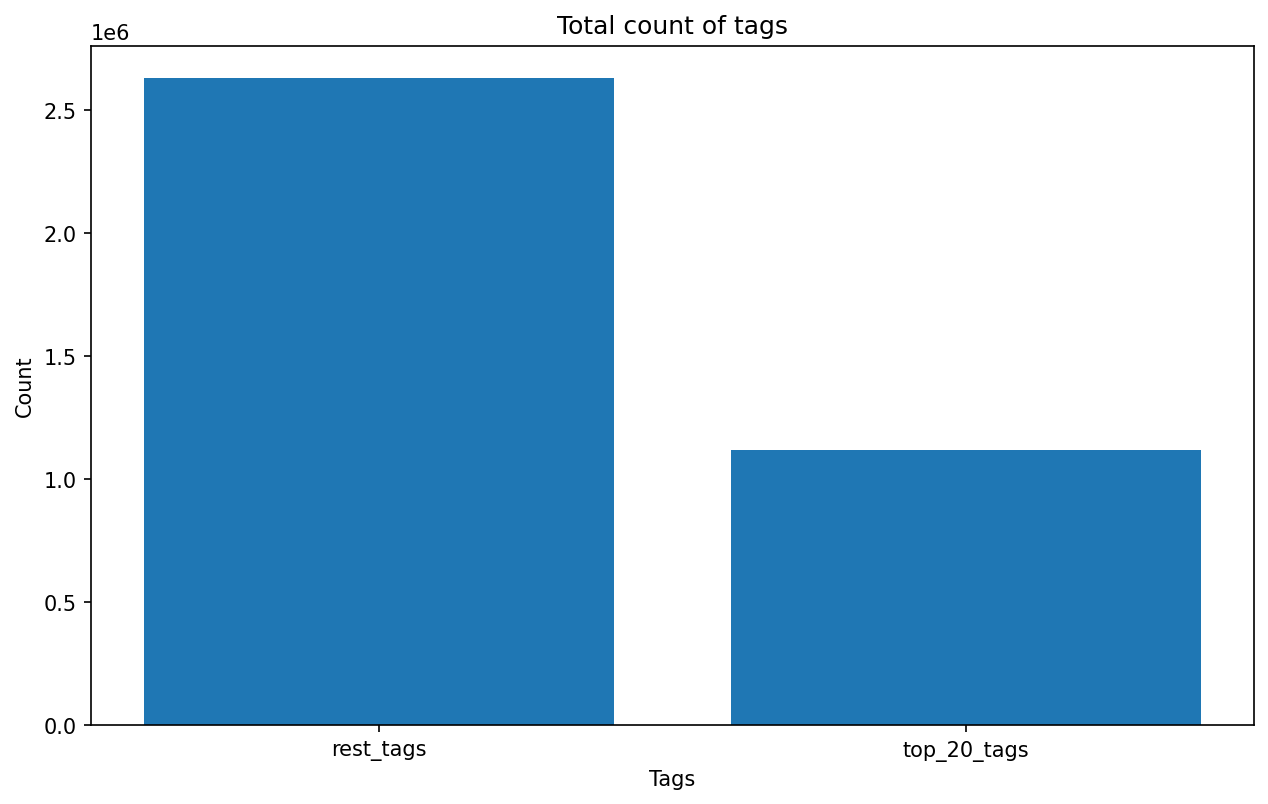

In [0]:
# plot the dataframe
import matplotlib.pyplot as plt

# Extract the values from the DataFrames
rest_tags = total_rest_tags.select("rest_tags").toPandas()
top_20_tags = top_20_tag_total.select("top_20_total").toPandas()

#clear settings for matplotlib
plt.clf()

# set the size of the graph that will be plotted
plt.figure(figsize=(10,6),dpi=150)

# Create the bar chart
plt.bar(["rest_tags", "top_20_tags"], [rest_tags["rest_tags"][0], top_20_tags["top_20_total"][0]])

# Add a title and axis labels
plt.title("Total count of tags")
plt.xlabel("Tags")
plt.ylabel("Count")

# Display the chart
plt.show()

#### A users answer score will improve over time

This test will be carried out for the most active users only as otherwise there is too much data to decipher the charts

In [0]:
from pyspark.sql.functions import count

# Get the 5 most active users
active_users = dfans_process.groupBy("userid").agg(count("*").alias("count")).sort("count", ascending=False).limit(5)
active_users.show()

+-------+-----+
| userid|count|
+-------+-----+
|  22656| 3270|
|1144035| 3009|
|  29407| 2144|
| 548225| 1924|
| 115145| 1813|
+-------+-----+



In [0]:
# create views for use by sql
dfans_process.createOrReplaceTempView("Answers")
active_users.createOrReplaceTempView("ActiveUsers")

# create a dataframe with the data for the most active users
activeusers = spark.sql("select A.userid, A.answerdate, A.score from Answers A inner join ActiveUsers AU ON A.userid = AU.userid order by A.userid")
activeusers.show(5)

+------+-------------------+-----+
|userid|         answerdate|score|
+------+-------------------+-----+
| 22656|2008-09-26 13:16:16|   13|
| 22656|2008-09-30 12:59:42|    2|
| 22656|2008-09-30 19:59:40|    2|
| 22656|2008-09-30 21:59:55|    5|
| 22656|2008-10-01 05:23:10|    6|
+------+-------------------+-----+
only showing top 5 rows



In [0]:
import pandas as pd

# convert the spark dataframe to a pandas dataframe
activeuserspd = activeusers.toPandas()
activeuserspd.head()

,userid,answerdate,score
0,22656,2008-09-26 13:16:16,13
1,22656,2008-09-30 12:59:42,2
2,22656,2008-09-30 19:59:40,2
3,22656,2008-09-30 21:59:55,5
4,22656,2008-10-01 05:23:10,6


In [0]:
# create a pivottable which will be used for plotting the time series graph
activeuserspv = activeuserspd.pivot(index='answerdate', columns='userid', values='score')
activeuserspv.head()

userid,22656,29407,115145,548225,1144035
answerdate,,,,,
2008-09-26 13:16:16,13.0,NaN,NaN,NaN,NaN
2008-09-30 12:59:42,2.0,NaN,NaN,NaN,NaN
2008-09-30 19:59:40,2.0,NaN,NaN,NaN,NaN
2008-09-30 21:59:55,5.0,NaN,NaN,NaN,NaN
2008-10-01 05:23:10,6.0,NaN,NaN,NaN,NaN


<Figure size 432x288 with 0 Axes>

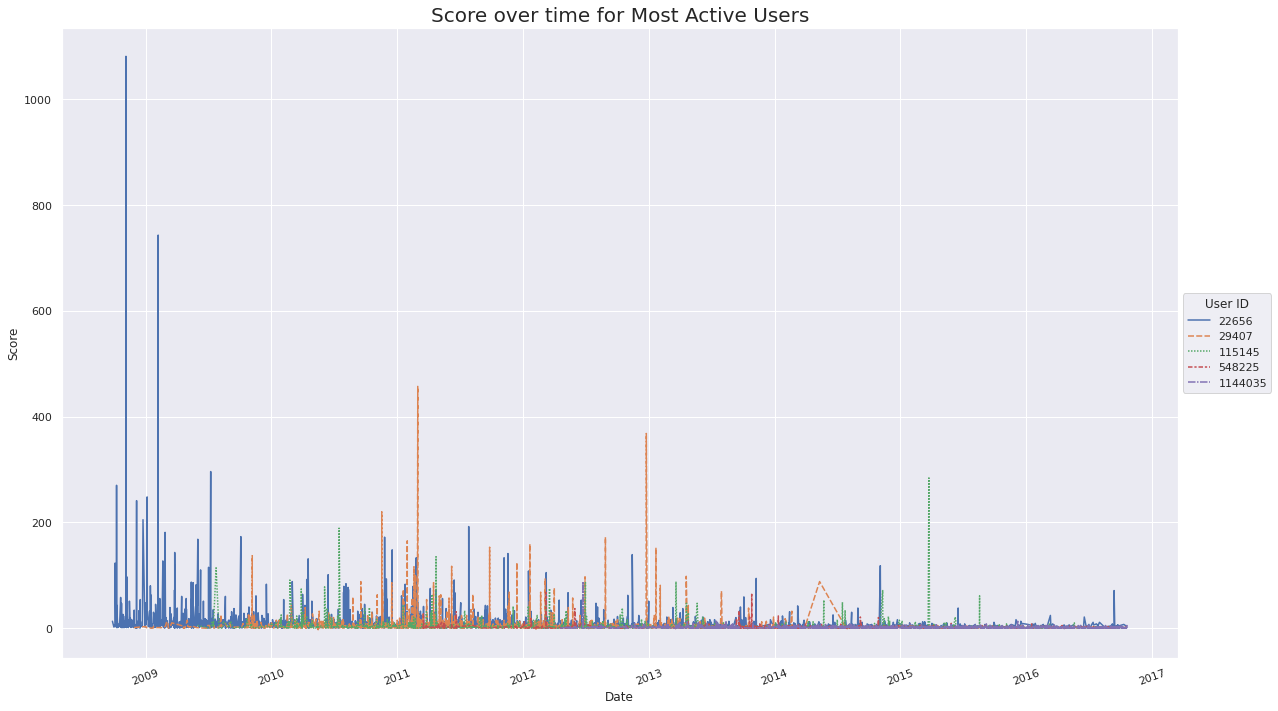

In [0]:
# Plot the findings
import matplotlib.pyplot as plt
import seaborn as sns

#reset the seaborn settings
sns.set()

#clear settings for matplotlib
plt.clf()

# set the size of the graph that will be plotted
plt.figure(figsize=(20,12))

# use seaborn lineplot to plot the data in the pivot table
sns.lineplot(data=activeuserspv)

# # Add title to the figure
# plt.suptitle('Answer Score over Time', fontsize=20, y=0.9)

# Configure the plot
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Score over time for Most Active Users', fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='User ID')
plt.xticks(rotation=20)
plt.subplots_adjust(bottom=0.15)

# Show the plot
plt.show()

<Figure size 432x288 with 0 Axes>

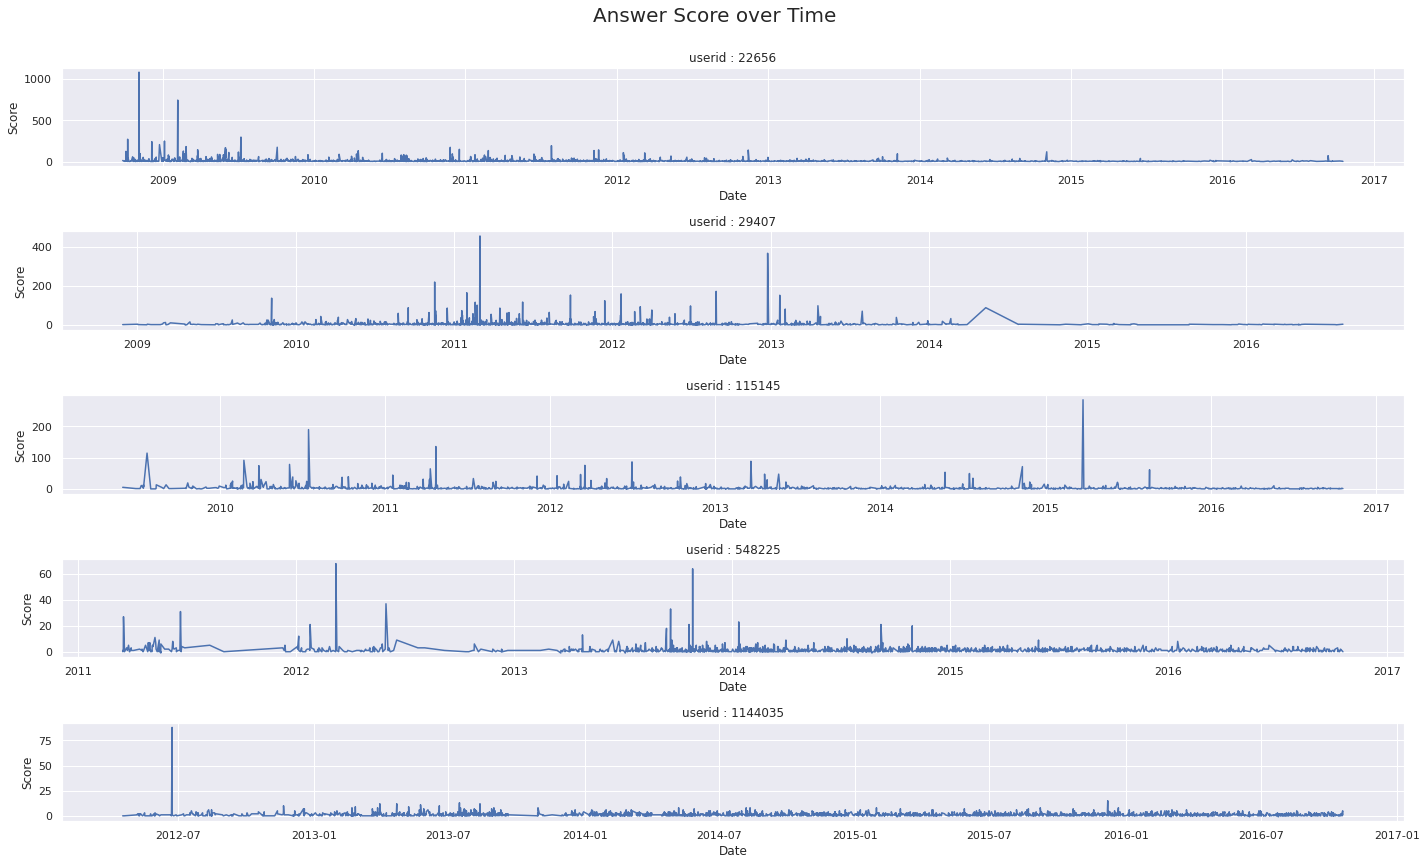

In [0]:
#clear settings for matplotlib
plt.clf()

# Add title to the figure
plt.suptitle('Answer Score over Time', fontsize=20, y=1.05)

# set the number of rows and columns that will be used in the subplots
nrows = len(activeuserspv.columns)
ncols = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(20,12))
axs = axs.flat

# iterate over the userid to plot a subplot for each userid
for i, userid in enumerate(activeuserspv.columns):
    sns.lineplot(x=activeuserspv.index, y=activeuserspv[userid], ax=axs[i])
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Date')
    axs[i].set_title('userid : '+ str(userid))
    
# Add title
plt.suptitle('Answer Score over Time', fontsize=20, y=1.0)

plt.tight_layout()

We can see from the graphs of the most active users providing answers that scores do not improve over time